In [ ]:
# Install required libraries (if needed)
!pip install scikit-learn pandas numpy matplotlib seaborn imbalanced-learn xgboost

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
import json
from google.colab import files
import warnings
warnings.filterwarnings('ignore')

# Set visualization style
sns.set_style("whitegrid")
plt.style.use("ggplot")

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving disasterData.json to disasterData.json


In [ ]:
with open('disasterData.json', 'r') as f:
    data = json.load(f)
df = pd.DataFrame(data)

print("Dataset shape:", df.shape)
print("\nFirst 5 entries:")
print(df.head())

Dataset shape: (14644, 9)

First 5 entries:
    type           subtype  year     country    deaths  injured   affected  \
0  Flood              None  1970   Argentina      36.0      NaN        NaN   
1  Storm  Tropical cyclone  1970   Australia      13.0      NaN        NaN   
2  Flood              None  1970       Benin       NaN      NaN        NaN   
3  Storm  Tropical cyclone  1970  Bangladesh  300000.0      NaN  3648000.0   
4  Storm              None  1970  Bangladesh      17.0      NaN      110.0   

  latitude longitude  
0     None      None  
1     None      None  
2     None      None  
3     None      None  
4     None      None  


In [ ]:
# Handle missing values
df['deaths'] = df['deaths'].fillna(df['deaths'].median())
df['injured'] = df['injured'].fillna(df['injured'].median())
df['affected'] = df['affected'].fillna(df['affected'].median())

# Drop unnecessary columns
df = df.drop(['subtype', 'latitude', 'longitude'], axis=1)

print("\nMissing values after cleaning:")
print(df.isnull().sum())


Missing values after cleaning:
type        0
year        0
country     0
deaths      0
injured     0
affected    0
dtype: int64


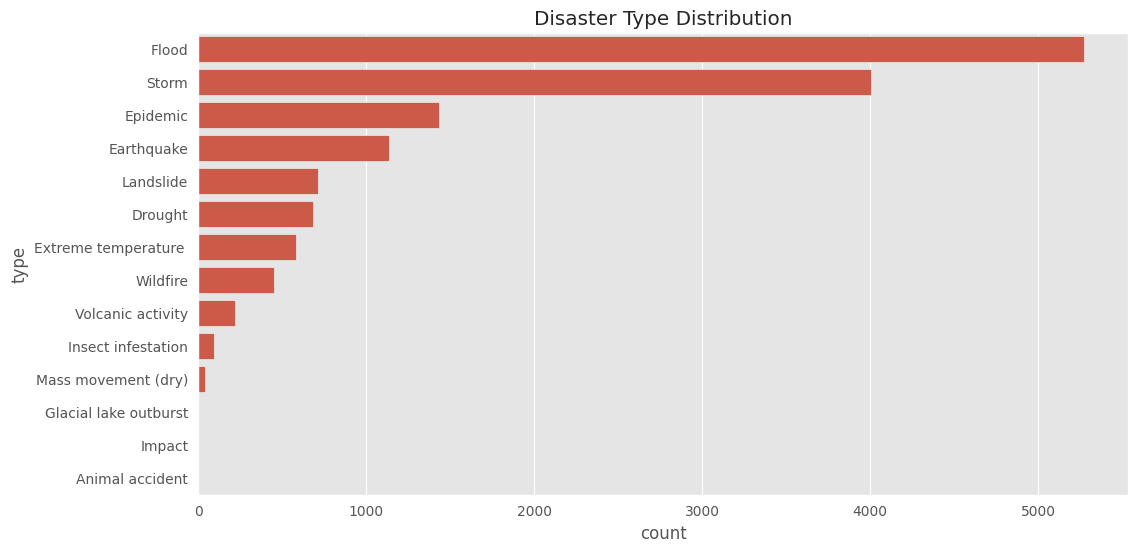

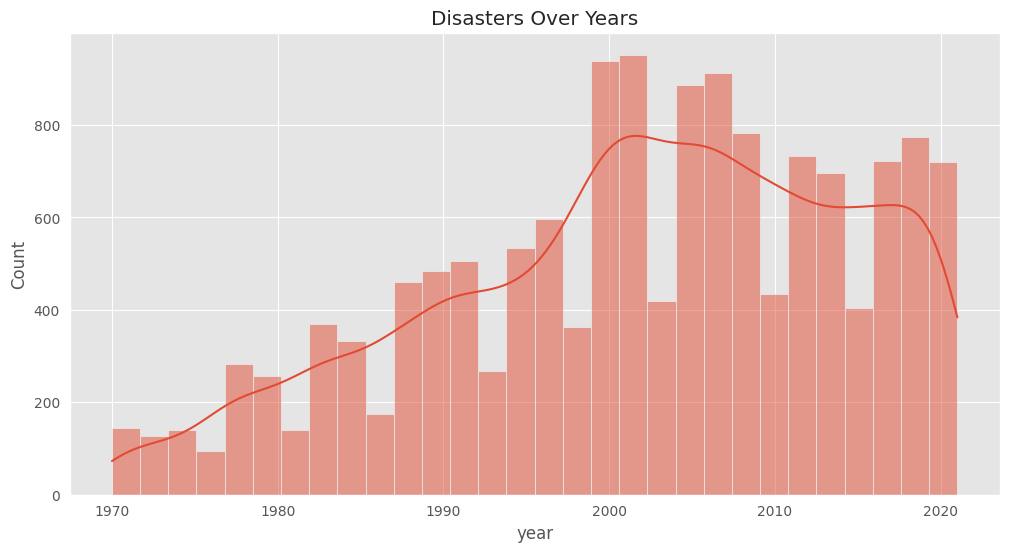

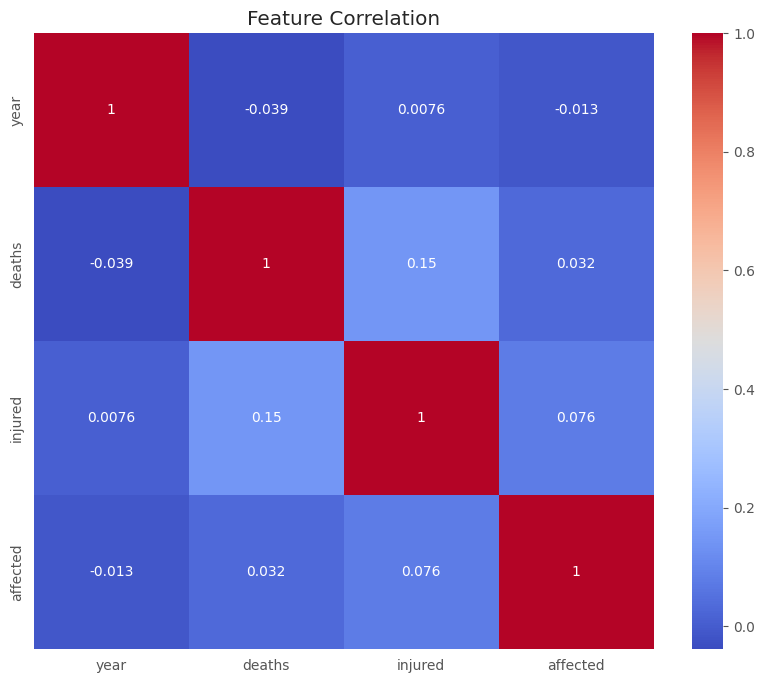

In [ ]:
# Disaster Type Distribution
plt.figure(figsize=(12, 6))
sns.countplot(y='type', data=df, order=df['type'].value_counts().index)
plt.title('Disaster Type Distribution')
plt.show()

# Yearly Distribution
plt.figure(figsize=(12, 6))
sns.histplot(df['year'], bins=30, kde=True)
plt.title('Disasters Over Years')
plt.show()

# Correlation Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(df[['year','deaths','injured','affected']].corr(),
            annot=True, cmap='coolwarm')
plt.title('Feature Correlation')
plt.show()

In [ ]:
!pip install imbalanced-learn

In [ ]:
from imblearn.over_sampling import SMOTE

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load your data (replace with your actual data loading)
# df = pd.read_json('disasterData.json')

# Data Preparation
# --------------------------------------------------------------------
# 1. Handle missing values
df['deaths'] = df['deaths'].fillna(0)
df['injured'] = df['injured'].fillna(0)
df['affected'] = df['affected'].fillna(0)

# 2. Prepare features and target
X = df[['year', 'country', 'deaths', 'injured', 'affected']]  # Include country as string
y = df['type']  # Disaster types

# 3. Encode target variable
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Preprocessing Pipeline
# --------------------------------------------------------------------
# Define numerical and categorical features
numerical_features = ['year', 'deaths', 'injured', 'affected']
categorical_features = ['country']

# Create transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Class Balancing with SMOTE (applied after train-test split to avoid data leakage)
# --------------------------------------------------------------------
print("Original class distribution:")
print(pd.Series(y).value_counts())

# Identify and handle small classes
class_counts = Counter(y_encoded)
small_classes = [cls for cls, count in class_counts.items() if count < 2]

if len(small_classes) > 0:
    print(f"\nRemoving classes with <2 samples: {[le.inverse_transform([cls])[0] for cls in small_classes]}")
    mask = ~np.isin(y_encoded, small_classes)
    X_filtered = X[mask]
    y_filtered = y_encoded[mask]
else:
    X_filtered = X
    y_filtered = y_encoded

# Train-test split before SMOTE
X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.3, random_state=42)

# Apply preprocessing
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# Apply SMOTE only to training data
try:
    smote = SMOTE(random_state=42, k_neighbors=min(2, len(X_train_preprocessed)-1))
    X_res, y_res = smote.fit_resample(X_train_preprocessed, y_train)
    print("\nNew class distribution after SMOTE:")
    print(pd.Series(le.inverse_transform(y_res)).value_counts())
except Exception as e:
    print(f"\nSMOTE failed: {e}")
    print("Using original training data without oversampling")
    X_res, y_res = X_train_preprocessed, y_train

print(f"\nFinal dataset shapes:")
print(f"X_train: {X_res.shape}, y_train: {y_res.shape}")
print(f"X_test: {X_test_preprocessed.shape}, y_test: {y_test.shape}")

Original class distribution:
type
Flood                    5272
Storm                    4005
Epidemic                 1436
Earthquake               1137
Landslide                 713
Drought                   685
Extreme temperature       584
Wildfire                  452
Volcanic activity         222
Insect infestation         93
Mass movement (dry)        41
Glacial lake outburst       2
Impact                      1
Animal accident             1
Name: count, dtype: int64

Removing classes with <2 samples: ['Impact', 'Animal accident']

SMOTE failed: sparse array length is ambiguous; use getnnz() or shape[0]
Using original training data without oversampling

Final dataset shapes:
X_train: (10249, 228), y_train: (10249,)
X_test: (4393, 228), y_test: (4393,)


In [ ]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [ ]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "SVM": SVC(kernel='rbf', probability=True),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100)
}

# Train and evaluate models
for name, model in models.items():
    print(f"\nTraining {name}...")
    model.fit(X_res, y_res)
    score = model.score(X_test_preprocessed, y_test)
    print(f"{name} Test Accuracy: {score:.2f}")



Training Logistic Regression...
Logistic Regression Test Accuracy: 0.48

Training Random Forest...
Random Forest Test Accuracy: 0.57

Training SVM...
SVM Test Accuracy: 0.48

Training KNN...
KNN Test Accuracy: 0.44

Training Gradient Boosting...
Gradient Boosting Test Accuracy: 0.56


In [ ]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)

    # Metrics
    print(f"\n{model.__class__.__name__} Performance:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='weighted'))
    print("Recall:", recall_score(y_test, y_pred, average='weighted'))
    print("F1-Score:", f1_score(y_test, y_pred, average='weighted'))

    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.show()

    # Classification Report
    print(classification_report(y_test, y_pred))


Evaluating Logistic Regression

LogisticRegression Performance:
Accuracy: 0.48304120191213296
Precision: 0.42033744660572814
Recall: 0.48304120191213296
F1-Score: 0.4162949400471978


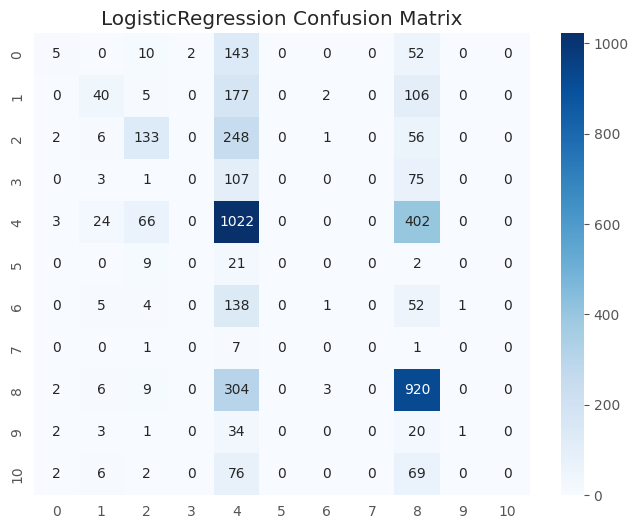

              precision    recall  f1-score   support

           1       0.31      0.02      0.04       212
           2       0.43      0.12      0.19       330
           3       0.55      0.30      0.39       446
           4       0.00      0.00      0.00       186
           5       0.45      0.67      0.54      1517
           8       0.00      0.00      0.00        32
           9       0.14      0.00      0.01       201
          10       0.00      0.00      0.00         9
          11       0.52      0.74      0.61      1244
          12       0.50      0.02      0.03        61
          13       0.00      0.00      0.00       155

    accuracy                           0.48      4393
   macro avg       0.26      0.17      0.16      4393
weighted avg       0.42      0.48      0.42      4393


Evaluating Random Forest

RandomForestClassifier Performance:
Accuracy: 0.5681766446619622
Precision: 0.5647288624568281
Recall: 0.5681766446619622
F1-Score: 0.557052895777166


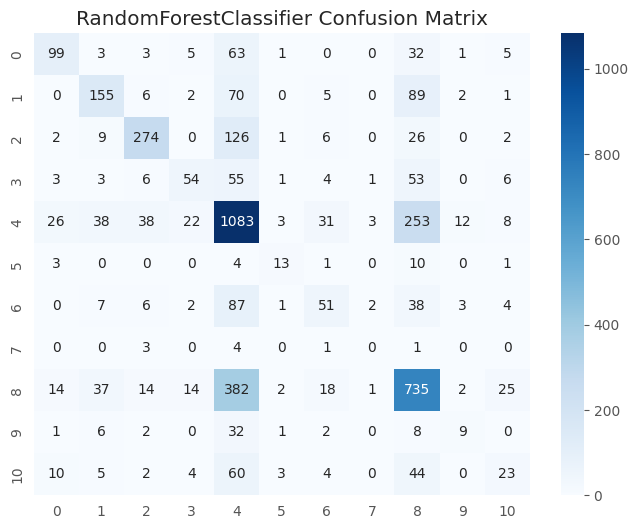

              precision    recall  f1-score   support

           1       0.63      0.47      0.54       212
           2       0.59      0.47      0.52       330
           3       0.77      0.61      0.69       446
           4       0.52      0.29      0.37       186
           5       0.55      0.71      0.62      1517
           8       0.50      0.41      0.45        32
           9       0.41      0.25      0.31       201
          10       0.00      0.00      0.00         9
          11       0.57      0.59      0.58      1244
          12       0.31      0.15      0.20        61
          13       0.31      0.15      0.20       155

    accuracy                           0.57      4393
   macro avg       0.47      0.37      0.41      4393
weighted avg       0.56      0.57      0.56      4393


Evaluating SVM

SVC Performance:
Accuracy: 0.47848850443888
Precision: 0.4701017088444244
Recall: 0.47848850443888
F1-Score: 0.4088523575299087


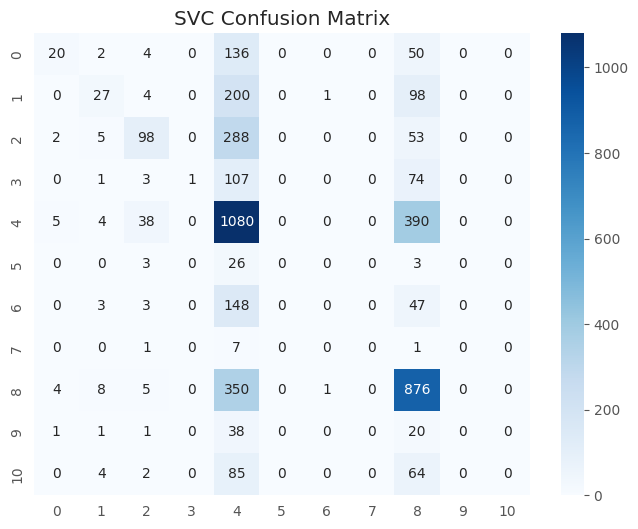

              precision    recall  f1-score   support

           1       0.62      0.09      0.16       212
           2       0.49      0.08      0.14       330
           3       0.60      0.22      0.32       446
           4       1.00      0.01      0.01       186
           5       0.44      0.71      0.54      1517
           8       0.00      0.00      0.00        32
           9       0.00      0.00      0.00       201
          10       0.00      0.00      0.00         9
          11       0.52      0.70      0.60      1244
          12       0.00      0.00      0.00        61
          13       0.00      0.00      0.00       155

    accuracy                           0.48      4393
   macro avg       0.33      0.17      0.16      4393
weighted avg       0.47      0.48      0.41      4393


Evaluating KNN

KNeighborsClassifier Performance:
Accuracy: 0.43546551331664013
Precision: 0.4147306500772094
Recall: 0.43546551331664013
F1-Score: 0.41713863408229174


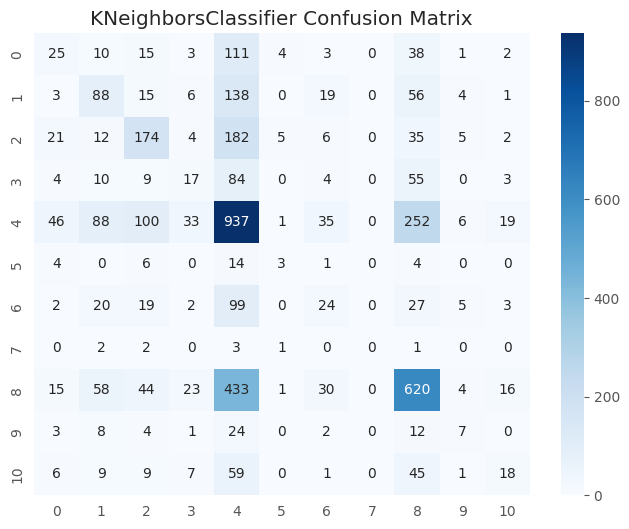

              precision    recall  f1-score   support

           1       0.19      0.12      0.15       212
           2       0.29      0.27      0.28       330
           3       0.44      0.39      0.41       446
           4       0.18      0.09      0.12       186
           5       0.45      0.62      0.52      1517
           8       0.20      0.09      0.13        32
           9       0.19      0.12      0.15       201
          10       0.00      0.00      0.00         9
          11       0.54      0.50      0.52      1244
          12       0.21      0.11      0.15        61
          13       0.28      0.12      0.16       155

    accuracy                           0.44      4393
   macro avg       0.27      0.22      0.23      4393
weighted avg       0.41      0.44      0.42      4393


Evaluating Gradient Boosting

GradientBoostingClassifier Performance:
Accuracy: 0.5611199635784202
Precision: 0.5710317610429614
Recall: 0.5611199635784202
F1-Score: 0.5425926115476607


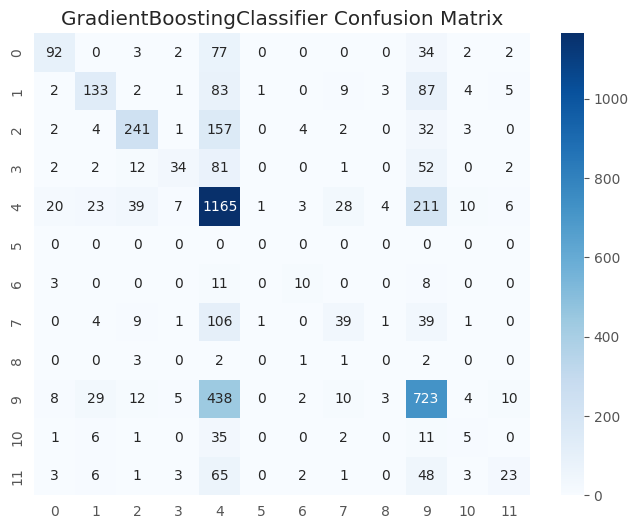

              precision    recall  f1-score   support

           1       0.69      0.43      0.53       212
           2       0.64      0.40      0.50       330
           3       0.75      0.54      0.63       446
           4       0.63      0.18      0.28       186
           5       0.52      0.77      0.62      1517
           6       0.00      0.00      0.00         0
           8       0.45      0.31      0.37        32
           9       0.42      0.19      0.27       201
          10       0.00      0.00      0.00         9
          11       0.58      0.58      0.58      1244
          12       0.16      0.08      0.11        61
          13       0.48      0.15      0.23       155

    accuracy                           0.56      4393
   macro avg       0.44      0.30      0.34      4393
weighted avg       0.57      0.56      0.54      4393



In [ ]:
for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Evaluating {name}")
    evaluate_model(model, X_test_preprocessed, y_test)


Model Comparison:
                 Model  Accuracy  Precision    Recall  F1-Score
0  Logistic Regression  0.483041   0.420337  0.483041  0.416295
1        Random Forest  0.568177   0.564729  0.568177  0.557053
2                  SVM  0.478489   0.470102  0.478489  0.408852
3                  KNN  0.435466   0.414731  0.435466  0.417139
4    Gradient Boosting  0.561120   0.571032  0.561120  0.542593


<Figure size 1200x600 with 0 Axes>

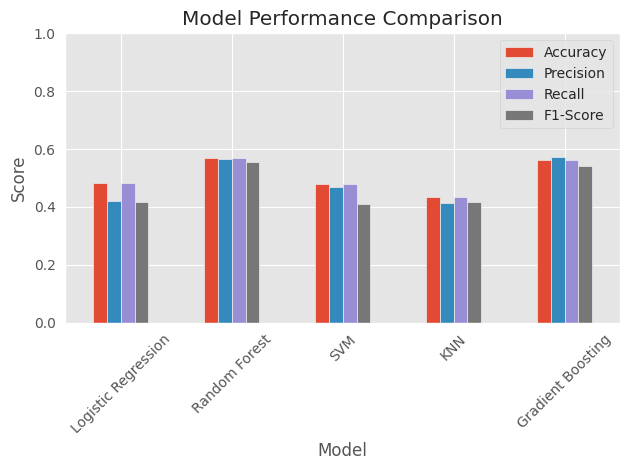

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import pandas as pd
import matplotlib.pyplot as plt

# Make sure X_test is properly preprocessed (use X_test_preprocessed instead)
results = []
for name, model in models.items():
    try:
        # Use the preprocessed test data
        y_pred = model.predict(X_test_preprocessed)

        results.append({
            'Model': name,
            'Accuracy': accuracy_score(y_test, y_pred),
            'Precision': precision_score(y_test, y_pred, average='weighted'),
            'Recall': recall_score(y_test, y_pred, average='weighted'),
            'F1-Score': f1_score(y_test, y_pred, average='weighted')
        })
    except Exception as e:
        print(f"Error evaluating {name}: {str(e)}")
        continue

# Create comparison dataframe
if results:  # Only proceed if we have results
    results_df = pd.DataFrame(results)

    # Print comparison table
    print("\nModel Comparison:")
    print(results_df)

    # Plot comparison
    plt.figure(figsize=(12, 6))
    results_df.set_index('Model').plot(kind='bar', rot=45)
    plt.title('Model Performance Comparison')
    plt.ylabel('Score')
    plt.ylim(0, 1)
    plt.tight_layout()
    plt.show()
else:
    print("No models were successfully evaluated.")

In [ ]:
import joblib
import os
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingClassifier

# Load your original dataset to get all categories
df = pd.read_json('disasterData.json')

# 1. Create and fit encoders with ALL actual data
le_country = LabelEncoder()
le_country.fit(df['country'].unique())  # All countries in your data

le_disaster = LabelEncoder()
le_disaster.fit(df['type'].unique())  # All disaster types in your data

# 2. Prepare and fit scaler with actual numerical data
scaler = StandardScaler()
numerical_data = df[['year', 'deaths', 'injured', 'affected']].fillna(0).values
scaler.fit(numerical_data)

# 3. Initialize model (you should replace this with your actual trained model)
model = GradientBoostingClassifier(n_estimators=100)
# If you already have a trained model:
# model.fit(X_train, y_train)  # Uncomment and use your actual training data

# 4. Save all components
os.makedirs('saved_models', exist_ok=True)

joblib.dump(model, 'saved_models/best_model.pkl')
joblib.dump(le_country, 'saved_models/country_encoder.pkl')
joblib.dump(le_disaster, 'saved_models/disaster_encoder.pkl')
joblib.dump(scaler, 'saved_models/scaler.pkl')

print("All components saved with complete category coverage:")
print(f"- Countries: {len(le_country.classes_)} unique")
print(f"- Disaster types: {len(le_disaster.classes_)} unique")

# 5. Optional Google Drive backup
try:
    from google.colab import drive
    drive.mount('/content/drive')
    !cp -r saved_models /content/drive/MyDrive/
    print("Successfully backed up to Google Drive")
except:
    print("Google Drive backup skipped - local save only")

All components saved with complete category coverage:
- Countries: 228 unique
- Disaster types: 14 unique
Google Drive backup skipped - local save only


In [ ]:
!pip install gradio scikit-learn -q
import gradio as gr
import joblib
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Load and prepare your data
df = pd.read_json('disasterData.json')

# Fill missing values
df['deaths'] = df['deaths'].fillna(0)
df['injured'] = df['injured'].fillna(0)
df['affected'] = df['affected'].fillna(0)

# 2. Encode categorical variables
le_country = LabelEncoder()
le_disaster = LabelEncoder()

df['country_encoded'] = le_country.fit_transform(df['country'])
df['type_encoded'] = le_disaster.fit_transform(df['type'])

# 3. Prepare features and target
X = df[['year', 'country_encoded', 'deaths', 'injured', 'affected']]
y = df['type_encoded']

# 4. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 6. Train the model
model = GradientBoostingClassifier(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)  # THIS IS THE CRUCIAL STEP THAT WAS MISSING

# 7. Save all components
import os
os.makedirs('saved_models', exist_ok=True)

joblib.dump(model, 'saved_models/best_model.pkl')
joblib.dump(le_country, 'saved_models/country_encoder.pkl')
joblib.dump(le_disaster, 'saved_models/disaster_encoder.pkl')
joblib.dump(scaler, 'saved_models/scaler.pkl')

# 8. Prediction function
def predict_disaster(year, country, deaths=0, injured=0, affected=0):
    try:
        # Load components
        model = joblib.load('saved_models/best_model.pkl')
        le_country = joblib.load('saved_models/country_encoder.pkl')
        le_disaster = joblib.load('saved_models/disaster_encoder.pkl')
        scaler = joblib.load('saved_models/scaler.pkl')

        # Validate inputs
        if not 1900 <= year <= 2100:
            return {"error": "Year must be between 1900-2100"}

        # Encode country
        try:
            country_code = le_country.transform([country])[0]
        except ValueError:
            return {"error": f"Country '{country}' not in our database"}

        # Prepare input
        input_data = np.array([[year, country_code, deaths, injured, affected]])
        input_scaled = scaler.transform(input_data)

        # Predict
        probabilities = model.predict_proba(input_scaled)[0]
        disasters = le_disaster.classes_

        # Format results
        top_3 = sorted(zip(disasters, probabilities), key=lambda x: x[1], reverse=True)[:3]

        return {
            "top_predictions": [{"disaster": d, "probability": float(p)} for d, p in top_3],
            "all_disasters": {d: float(p) for d, p in zip(disasters, probabilities)}
        }
    except Exception as e:
        return {"error": f"System error: {str(e)}"}

# 9. Create Gradio interface
inputs = [
    gr.Number(label="Year", value=2023, minimum=1900, maximum=2100),
    gr.Dropdown(label="Country", choices=sorted(le_country.classes_), value="India"),
    gr.Number(label="Deaths (optional)", value=0, minimum=0),
    gr.Number(label="Injured (optional)", value=0, minimum=0),
    gr.Number(label="Affected (optional)", value=0, minimum=0)
]

demo = gr.Interface(
    fn=predict_disaster,
    inputs=inputs,
    outputs=gr.JSON(),
    title="🌍 Disaster Prediction System",
    examples=[
        [2023, "India", 50, 100, 1000],
        [2025, "United States", 10, 30, 500]
    ]
)

demo.launch()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.6/322.6 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 94.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.3 MB/s eta 0:00:00
It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://bc4dd2965b55c05cd1.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory 

In [ ]:
!pip install gradio -q
import gradio as gr
import joblib
import numpy as np
from sklearn.preprocessing import LabelEncoder

# First load the encoders to get country choices
le_country = joblib.load('saved_models/country_encoder.pkl')

def predict_disaster(year, country, deaths=0, injured=0, affected=0):
    try:
        # Load all saved components
        model = joblib.load('saved_models/best_model.pkl')
        le_disaster = joblib.load('saved_models/disaster_encoder.pkl')
        scaler = joblib.load('saved_models/scaler.pkl')

        # Validate inputs
        if not isinstance(year, (int, float)) or year < 1900 or year > 2100:
            return {"error": "Year must be between 1900-2100"}

        # Encode country (handle unknown countries)
        try:
            country_code = le_country.transform([country])[0]
        except ValueError:
            country_code = -1  # Special code for unknown countries
            return {"error": f"Country '{country}' not in training data"}

        # Prepare input array with CORRECT feature order and count
        # Adjust this based on how you trained your model
        input_data = np.array([
            [year, deaths, injured, affected]  # Example - modify as needed
        ])

        # Scale features
        input_scaled = scaler.transform(input_data)

        # Get predictions
        probabilities = model.predict_proba(input_scaled)[0]
        disaster_classes = le_disaster.classes_

        # Get top 3 predictions
        top_3_idx = np.argsort(probabilities)[-3:][::-1]
        predictions = [
            {
                "disaster": disaster_classes[i],
                "probability": float(probabilities[i]),
                "risk_level": "High" if probabilities[i] > 0.7 else
                              "Medium" if probabilities[i] > 0.3 else "Low"
            }
            for i in top_3_idx
        ]

        return {
            "predictions": predictions,
            "all_probabilities": {d: float(p) for d, p in zip(disaster_classes, probabilities)}
        }

    except Exception as e:
        return {"error": f"Prediction failed: {str(e)}"}

# Create Gradio interface
inputs = [
    gr.Number(label="Year", value=2023, minimum=1900, maximum=2100),
    gr.Dropdown(
        label="Country",
        choices=sorted(le_country.classes_),
        value="India"
    ),
    gr.Number(label="Deaths (optional)", value=0, minimum=0),
    gr.Number(label="Injured (optional)", value=0, minimum=0),
    gr.Number(label="Affected (optional)", value=0, minimum=0)
]

outputs = gr.JSON(label="Prediction Results")

demo = gr.Interface(
    fn=predict_disaster,
    inputs=inputs,
    outputs=outputs,
    title="🌍 Disaster Prediction System",
    description="Predict likely disaster types based on country and year",
    examples=[
        [2023, "India", 50, 100, 1000],
        [2024, "United States", 10, 50, 500],
        [2025, "Japan", 5, 20, 200]
    ]
)

# Launch the interface
demo.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://99ef2aa73556fcbc45.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
# For a more advanced layout:
demo = gr.Blocks(title="Disaster Prediction")

with demo:
    gr.Markdown("## 🚨 Disaster Prediction System")
    with gr.Row():
        year = gr.Number(label="Year")
        country = gr.Dropdown(label="Country", choices=sorted(le_country.classes_))
    with gr.Row():
        deaths = gr.Number(label="Deaths (optional)")
        injured = gr.Number(label="Injured (optional)")
        affected = gr.Number(label="Affected (optional)")
    btn = gr.Button("Predict")
    output = gr.JSON()

    btn.click(
        fn=predict_disaster,
        inputs=[year, country, deaths, injured, affected],
        outputs=output
    )

demo.launch()

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d299995d2100793a7e.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
